In [1]:
# 데이터 출처: https://archive.ics.uci.edu/dataset/222/bank+marketing
# Github 출처: https://github.com/uci-ml-repo/ucimlrepo

#기본 모듈 불러오기 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

# 아래에서 따로 이용하는 모듈
from matplotlib.ticker import MultipleLocator
import math
from imblearn.over_sampling import SMOTENC

# # warning을 모두 무시하는 것은 좋지 않으나 과제 수행을 쉽게할 수 있도록 무시설정
# import warnings
# warnings.filterwarnings(action='ignore')

# 전체 계획
1. 데이터 로드 & 분리
    * train / test 데이터 분리
2. 탐색적 데이터 분석(EDA)
    * 분포확인 & 이상치 확인
3. 데이터 전처리
    * 이상치 제거
        - 범주형은 딱히 이상치라고 판단할 일이 없을 테니 수치형에 대해서만 생각해보면
        - 그리고 만약 이상치 제거했으면 꼭 index 리셋해주기
    * 데이터 비율 맞춰주기 위해 Oversampleing
        - 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
        - SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용
    * 결측치 처리 (참고로 test 데이터 기준으로는 데이터 총 31647, 전체 데이터로는 45211)
        - 수치형: contact(9100), poutcome(25917)
        - 범주형: job(206), education(1314)
        - 삭제 : -  
        처리하기 애매하다는 느낌 일단 내버려두고 차차 더 생각
    * 전처리
        - 수치형: 'age','balance','day_of_week','duration','campaign','pdays','previous'
        - 범주형: 'job','marital','education','default','housing','loan','contact','month','poutcome'
            - 레이블 인코딩: 
            - 원- 핫 인코딩: 
    
4. 모델 수립
5. 평가

# 1. 데이터 로드 & 분리

#### 문제1: 라이브러리를 통해 데이터 불러오기
- 다음코드는 데이터를 불러오고 df 변수명에 저장하는 코드입니다.
- github 문서를 읽고 데이터를 요청하여 로컬환경에 저장해보세요
- 뭔가 좀 무거운 것 같아서 주석처리해놨음

In [2]:
# 이거 쓰면 좀 렉걸리는 듯해서 첫 실행제외하고는 굳이 할 필요없어서 주석처리해둠
# # df2 = pd.read_csv('F:/sparta_python/ML/bank+marketing/bank-full.csv', sep=';') # 파일로 다운받아서 불러오는 경우
# # display(df2.head(3))
# from ucimlrepo import fetch_ucirepo, list_available_datasets
# # check which datasets can be imported
# # list_available_datasets()
# # import dataset
# Bank_Marketing = fetch_ucirepo(id=222)
# df = Bank_Marketing.data.original
# # df = pd.DataFrame(data=Bank_Marketing.data.original)
# df.to_csv('./bank_marketing.csv')

# # 확인용
# display(df.head(3)) #단 설명에 있는 컬럼과 올려진 파일 컬럼이 day_of_week로 설명되어있는게 파일에는 day로 되어있음

## 데이터 train과 test로 분리

In [3]:
# 데이터 불러오기 
df = pd.read_csv('./bank_marketing.csv') # 라이브러리를 통해 불러온 데이터를 저장하여 다시 파일로써 불러오는 것
# df2 = pd.read_csv('F:/sparta_python/ML/bank+marketing/bank-full.csv', sep=';') # 다운받은 데이터로 확인하는 법

# 우선 X와 y분리
X = df.drop(columns=['y']) # 제거 된채로 원본 df에 저장되는게 아님
y = df[['y']]

# 학습과 평가 위해서 train과 test로 나눠줌
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

# 수치형 데이터와 범주형 데이터 분류해서 저장
numeric_col = ['age','balance','day_of_week','duration','campaign','pdays','previous']
category_col = ['job','marital','education','default','housing','loan','contact','month','poutcome']

# 분리한 데이터 크기 확인
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31647, 17) (13564, 17) (31647, 1) (13564, 1)


# 2. EDA

education의 설명에 나와있는 범주 종류와 실제 데이터의 종류가 서로 다름      
day_of_week dow인 듯 한데 실제 데이터에 있는 값들은 7이상의 값들도 존재하며 다운 받았을 때 day로 되어있는 것을 통해 유추할 때는 일의미하는 듯   


### 결측치 확인
train데이터 기준으로 아래에서 확인해본 결과
- contact: 9100개, poutcome: 25917개
- job: 206개, education: 1314개 
- pdays: NaN값은 없음, -1로 표기된 것보고 결측치라 설명한듯?(이전 캠페인에서 연락하지 않은 경우) 25912개 존재
    
관련하여서 어떻게 처리해줄지는 심화부분에서 고민해보기

In [4]:
X_train.info()
X_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 31647 entries, 13382 to 3184
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   31647 non-null  int64 
 1   age          31647 non-null  int64 
 2   job          31441 non-null  object
 3   marital      31647 non-null  object
 4   education    30333 non-null  object
 5   default      31647 non-null  object
 6   balance      31647 non-null  int64 
 7   housing      31647 non-null  object
 8   loan         31647 non-null  object
 9   contact      22547 non-null  object
 10  day_of_week  31647 non-null  int64 
 11  month        31647 non-null  object
 12  duration     31647 non-null  int64 
 13  campaign     31647 non-null  int64 
 14  pdays        31647 non-null  int64 
 15  previous     31647 non-null  int64 
 16  poutcome     5730 non-null   object
dtypes: int64(8), object(9)
memory usage: 4.3+ MB


Unnamed: 0         0
age                0
job              206
marital            0
education       1314
default            0
balance            0
housing            0
loan               0
contact         9100
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       25917
dtype: int64

In [5]:
# # 각 컬럼별 데이터 확인해봤던 부분
# print(X_train['poutcome'].value_counts(),'\n')

# print(X_train['poutcome'].count(),'\n')

# print(X_train['contact'].value_counts(),'\n')

# # X_train 전체 유효한 갯수 확인해보는 다른 방식(해본바로는 위의 isna로 확인하는게 더 잘보이는 듯)
# print(X_train.shape,'\n')
# print(X_train.count(),'\n')

# print(X_train['pdays'].value_counts(),'\n')

# # df['pdays'].value_counts()
# print(X_train['pdays'].count(),'\n')

# print(X_train['poutcome'].value_counts(),'\n')

# print(X_train['previous'].nunique(),'\n') # 값 종류 갯수 확인 방법

### 기술통계를 통한 EDA

#### 모든 데이터

In [6]:
# 모든 데이터
X_train.describe(include = 'all')

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
count,31647.000000,31647.000000,31441,31647,30333,31647,31647.000000,31647,31647,22547,31647.000000,31647,31647.000000,31647.000000,31647.000000,31647.000000,5730
unique,NaN,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3
top,NaN,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure
freq,NaN,NaN,6866,19049,16201,31083,NaN,17625,26573,20517,NaN,9643,NaN,NaN,NaN,NaN,3378
mean,22602.388062,40.883022,NaN,NaN,NaN,NaN,1363.589535,NaN,NaN,NaN,15.806712,NaN,258.755143,2.760040,39.869498,0.584795,NaN
std,13044.705146,10.621809,NaN,NaN,NaN,NaN,3070.235315,NaN,NaN,NaN,8.331080,NaN,259.880162,3.104999,99.674113,2.490925,NaN
min,0.000000,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN
25%,11303.500000,33.000000,NaN,NaN,NaN,NaN,74.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN
50%,22595.000000,39.000000,NaN,NaN,NaN,NaN,451.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN
75%,33911.500000,48.000000,NaN,NaN,NaN,NaN,1427.500000,NaN,NaN,NaN,21.000000,NaN,318.000000,3.000000,-1.000000,0.000000,NaN


In [7]:
print(X_train['age'].value_counts().idxmax(), X_train['age'].value_counts().max()) # 메소드 공부용 (최빈값의 값, 빈도)

32 1460


pdays 'unique', 'top', 'freq' NaN로 나온 이유 : -1은 수치형 데이터에 데하여 통계 계산할 때 제외되기 때문이라는 듯(said gpt)     
    
describe에서 count는 공통적으로 다 표시되고,    
'unique', 'top', 'freq' 은 범주형의 경우에만 표시되고,  
mean, std, min, 25%, 75%, max는 수치형의 경우만 표시되며    
표시 되지 않을 경우에는 NaN으로

#### 수치형 데이터만

In [8]:
# 수치형 데이터만
X_train.describe()

,Unnamed: 0,age,balance,day_of_week,duration,campaign,pdays,previous
count,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000,31647.000000
mean,22602.388062,40.883022,1363.589535,15.806712,258.755143,2.760040,39.869498,0.584795
std,13044.705146,10.621809,3070.235315,8.331080,259.880162,3.104999,99.674113,2.490925
min,0.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,11303.500000,33.000000,74.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,22595.000000,39.000000,451.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,33911.500000,48.000000,1427.500000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,45210.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


#### 범주형 데이터만

In [9]:
# 범주형 데이터만
X_train.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,31441,31647,30333,31647,31647,31647,22547,31647,5730
unique,11,3,3,2,2,2,2,12,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,failure
freq,6866,19049,16201,31083,17625,26573,20517,9643,3378


### 시각화를 통한 EDA

#### 수치형 데이터 시각화

In [10]:
X_train['duration'].value_counts() #확인해본 결과 저렇게 이상하게 나오는 건 맞는데 확인할 때 계산해준 값으로 쓰인 것들이 이상함

duration
124     142
89      135
90      133
104     130
139     130
       ... 
2219      1
1294      1
1665      1
1489      1
1191      1
Name: count, Length: 1467, dtype: int64

In [11]:
# print(X_train['campaign'].max(),X_train['campaign'].min())
print(X_train['campaign'].value_counts().max(),'\n')

for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign']:
    print(check_col, " : ", len(set(X_train[check_col]))) # 중복없이 값종류 갯수

12294 

age  :  77
day_of_week  :  31
previous  :  41
balance  :  6255
duration  :  1467
campaign  :  47


In [12]:
# # 그래프 bin관련 파악 부분
# '''
# bin갯수 결정 알고리즘 : https://chat.openai.com/share/af07e311-7aa3-45fa-980e-ee69c2eb84c6
# Freedman-Diaconis' Choice방식 사용
# 데이터의 분포를 고려하여 bin의 폭을 결정한 후에 전체 데이터 범위를 그 폭으로 나누어 bin의 갯수를 계산
# 전체 데이터 범위는 그냥 최대값 - 최솟값으로 구한다고 한다 따라서 .max()-.min()을 해주면 될듯하다
# bin의 폭(bin width)은 2*(IQR/N**(1/3))으로 구하고
# IQR은 Q3 - Q1으로 Q3와 Q1는 np.percentile(data, 75)와 np.percentile(data, 25)로 구할 수 있다
# N은 데이터의 샘플 갯수로 왜인지는 모르겠지만 중복을 포함하여 총 데이터 값의 갯수라고 한다 .count()를 쓰면 될듯하다

# '''
# for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign']:
#     print(check_col, "의 최대, 최소값 : ", X_train[check_col].max(), X_train[check_col].min())
    
# print('\n')

# for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign', 'pdays']:
#     entire_range = X_train[check_col].max() - X_train[check_col].min()
#     q1 = np.percentile(X_train[check_col], 25)
#     q3 = np.percentile(X_train[check_col], 75)
#     IQR = q3 - q1
#     N = X_train[check_col].count()
#     distinct_n = X_train[check_col].nunique()
#     mean = X_train[check_col].mean()
#     std = X_train[check_col].std()
#     cv = X_train[check_col].std() / X_train[check_col].mean() #변동계수라는 값이라고 한다
#     skew = X_train[check_col].skew() #왜도
#     bin_width = 2 * (IQR / N**(1/3))
#     num_bin = entire_range / bin_width
#     print(check_col, "의 전체범위는 ", entire_range)
#     print(check_col, "의 q1과 q3는 ", q1, q3)
#     print(check_col, "의 IQR은 ", IQR)
#     print(check_col, "의 N은 ", N)
#     print(check_col, "의 distinct_n은 ", distinct_n)
#     print(check_col, "의 평균은 ", mean)
#     print(check_col, "의 표준편차는 ", std)
#     print(check_col, "의 변동계수는 ", cv)
#     print(check_col, "의 왜도는 ", skew)
#     print(check_col, "의 bin너비는 ", bin_width)
#     print(check_col, "의 bin갯수는 ", num_bin,'\n')
    
# for check_col in ['age', 'day_of_week', 'previous', 'balance', 'duration', 'campaign', 'pdays']:
#     entire_range = X_train[check_col].max() - X_train[check_col].min()
#     q1 = np.percentile(X_train[check_col], 25)
#     q3 = np.percentile(X_train[check_col], 75)
#     IQR = q3 - q1
#     N = X_train[check_col].count()
#     distinct_n = X_train[check_col].nunique()
#     bin_width = 2 * (IQR / N**(1/3))
#     num_bin = entire_range / bin_width
#     print(check_col, "의 bin갯수는 ", num_bin)

C:\Users\kssg1\AppData\Local\Temp\ipykernel_18972\1178725451.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


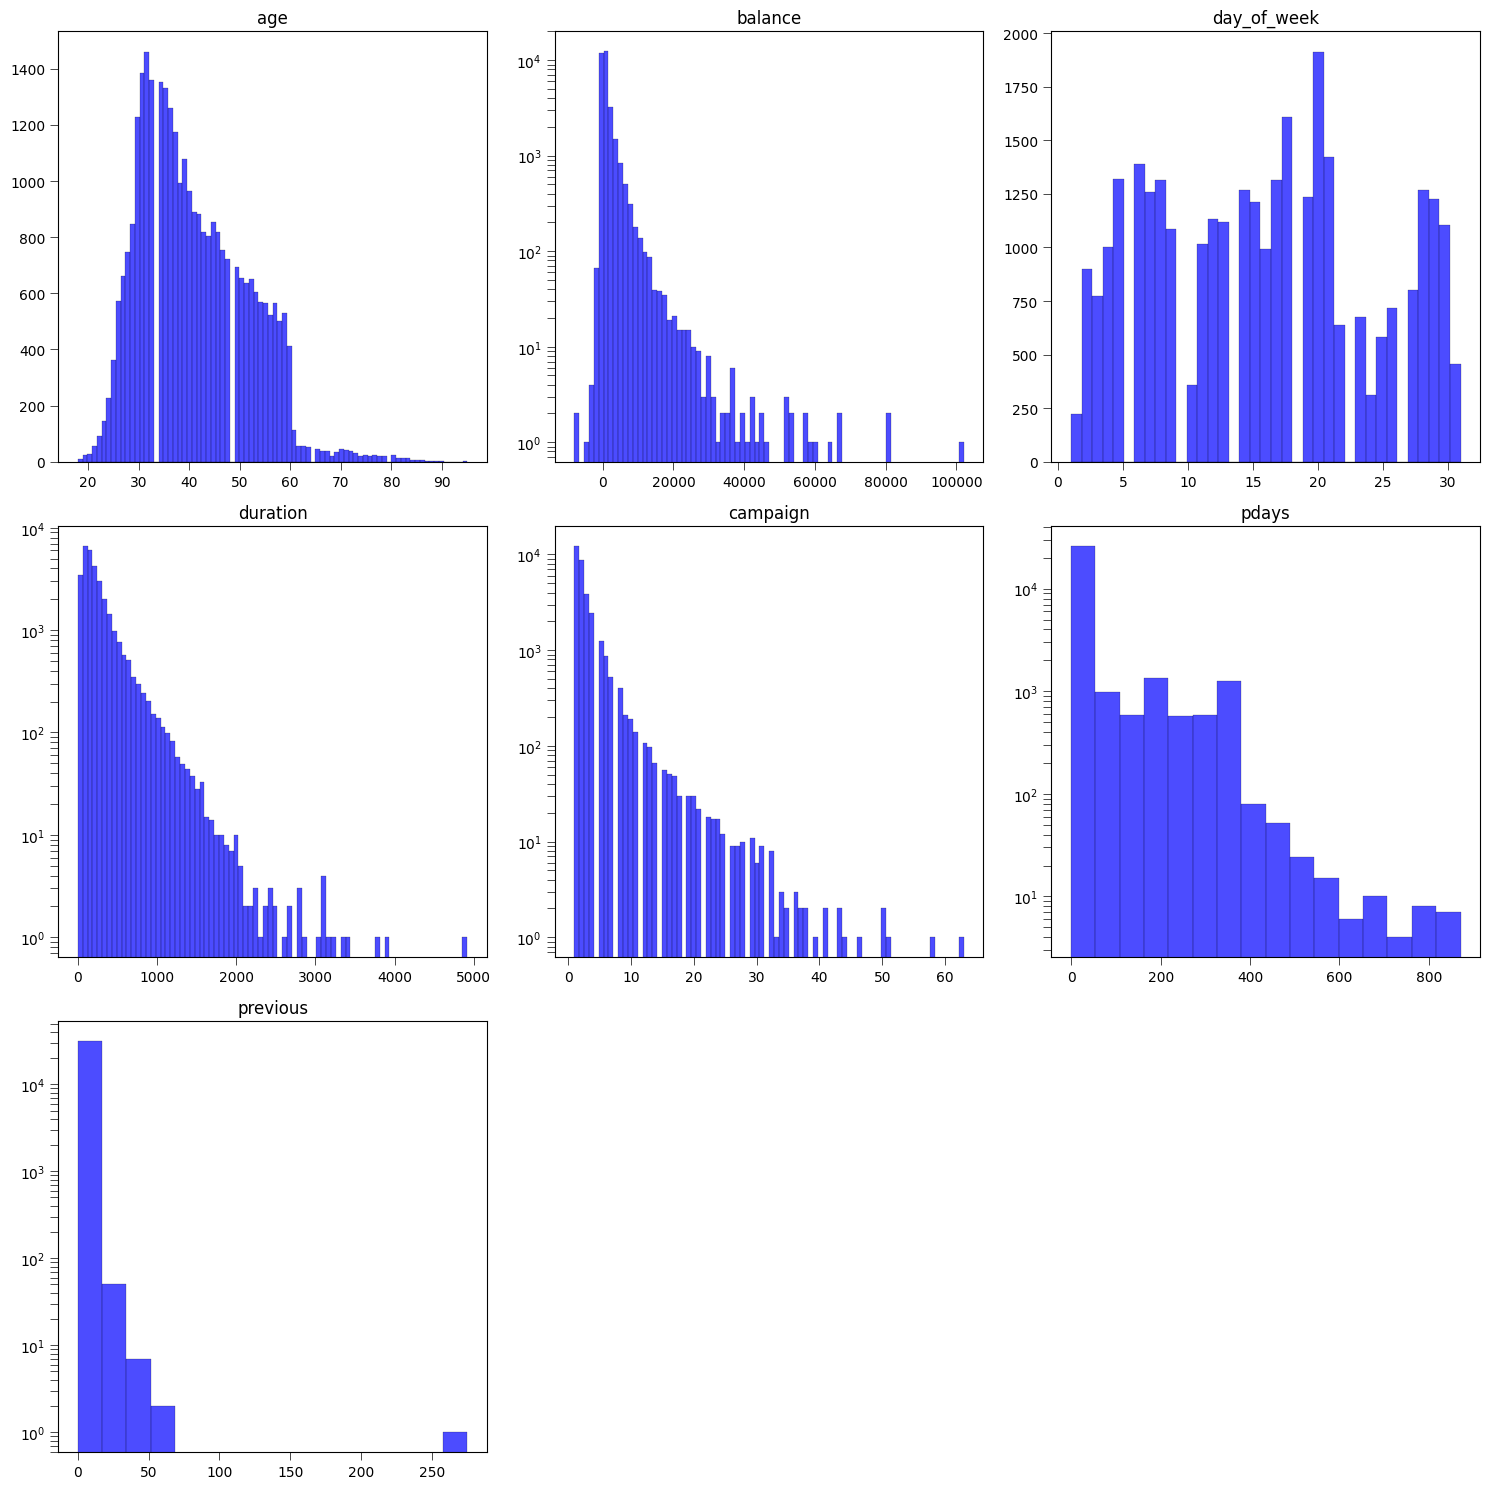

In [13]:
#수치형 변수 시각화
def get_3_hist_num(data:pd.DataFrame, columns:list, whether_log_scale: bool = True, 
                                        log_scale_threshold: float = 5000, num_bin_max: int = 300 ):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
        bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()
        
        # Freedman-Diaconis' Choice방식으로 bin 갯수 얼추 계산해본 뒤 판단
        entire_range = X_train[col].max() - X_train[col].min() # 데이터 값 최대와 최소 차이
        q1 = np.percentile(X_train[col], 25)
        q3 = np.percentile(X_train[col], 75)
        IQR = q3 - q1
        N = X_train[col].count()
        bin_width = 2 * (IQR / N**(1/3))
        num_bin = entire_range / bin_width
        # print(col, "의 bin : ", num_bin) # 점검용
        if (not math.isinf(num_bin)) and num_bin > num_bin_max:
            n_bins = 80
        else:
            n_bins = 'auto'
        
        # # Wand 규칙을 사용하여 동적으로 bin의 개수 설정
        # if bar_width_ratio < bar_width_ratio_min:  # 전체 스케일에 대한 막대 두께의 비율이 너무 작으면
        #     n_bins = int(np.sqrt(len(set(data[col])))*1.0) 
        #     # 조금더 줄이면 깔끔히 잘보이지 않을까해서 0.8곱했다가 별차이없는듯해서 1.0으로 원 위치(원래 곱해진 것 따로 없었음)
        # else:
        #     n_bins = 'auto'
            
        hist, bins, _ = axes[row_idx, col_idx].hist(data[col], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7)
        num_bin_actual = len(bins) - 1  # 실제로 그려진 막대의 갯수
        #sns.histplot(data[col], ax=axes[row_idx, col_idx], bins=n_bins, color='blue', edgecolor='blue', linewidth=0.2, alpha=0.7, kde=False)
        
        axes[row_idx, col_idx].set_title(col)
        axes[row_idx, col_idx].tick_params(axis='both', which='both', direction='out', length=6, width=0.5)  # 눈금 표시
        
        bar_heights = [rect.get_height() for rect in axes[row_idx, col_idx].patches]
        max_height = max(bar_heights)
        min_height = max(min(bar_heights),1)
        
        # print(col, " 높이차는 이러함 : ", max_height / min_height, max_height, min_height) # 점검용
        # print(col, " bin : ", num_bin_actual) # 점검용
        
        # 히스토그램 바의 높이 차이에 따라 리니어 스케일 또는 로그 스케일 선택
        if whether_log_scale == True and (max_height / min_height) > log_scale_threshold:
            axes[row_idx, col_idx].set_yscale('log')  # 로그 스케일로 변환
        else:
            axes[row_idx, col_idx].set_yscale('linear')  # 리니어 스케일로 유지
        
        # 전체 그래프 스케일에 대한 막대 자체의 두께 비율 계산
        total_width = axes[row_idx, col_idx].get_xlim()[1] - axes[row_idx, col_idx].get_xlim()[0]
        
        
        
        # 히스토그램 바의 두께가 조건에 따라 테두리 색 설정
        for rect in axes[row_idx, col_idx].patches:
            bar_width = rect.get_width()
            if bar_width / total_width > 0.005: # 그냥 저쯤보다 얇은 경우 테두리 없는게 나은듯해서 설정해줌
                rect.set_edgecolor('black')
            else:
                rect.set_edgecolor('none')  # 얇은 경우에는 테두리 없애기
        
        # # Seaborn axis 객체로부터 눈금 위치 확인
        # tick_locs = sns.histplot(data[col]).axes.get_xticks()
        # print(f"{col}의 현재 x 축 눈금 위치: {tick_locs}")

    # 남은 서브플롯에 빈 그래프 그리기
    for i in range(num_plots, num_rows * num_cols):
        row_idx, col_idx = divmod(i, 3)
        axes[row_idx, col_idx].clear()  # 남은 서브플롯 비우기
        axes[row_idx, col_idx].axis('off')  # 빈 서브플롯 제거
        
    

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()
get_3_hist_num(X_train, numeric_col)

여기부분 label 두번씩 나오는데 이거 확인하고 수정하기 ->어케 수정한지 자세히는 기억안나는데 어떻게든 일단 수정했고  
그리고 campaign 얘 먼데 그렇게 그래프 보기 힘들게 안나올만한 갯수들과 값차이 들인데 이상하게 나오는게 이상해서 데이터 살펴봐야할듯

수치형 시각화 판단 결과
이상치가 많아서 left skewness 발생한 경우 :log scale

#### 범주형 데이터 시각화

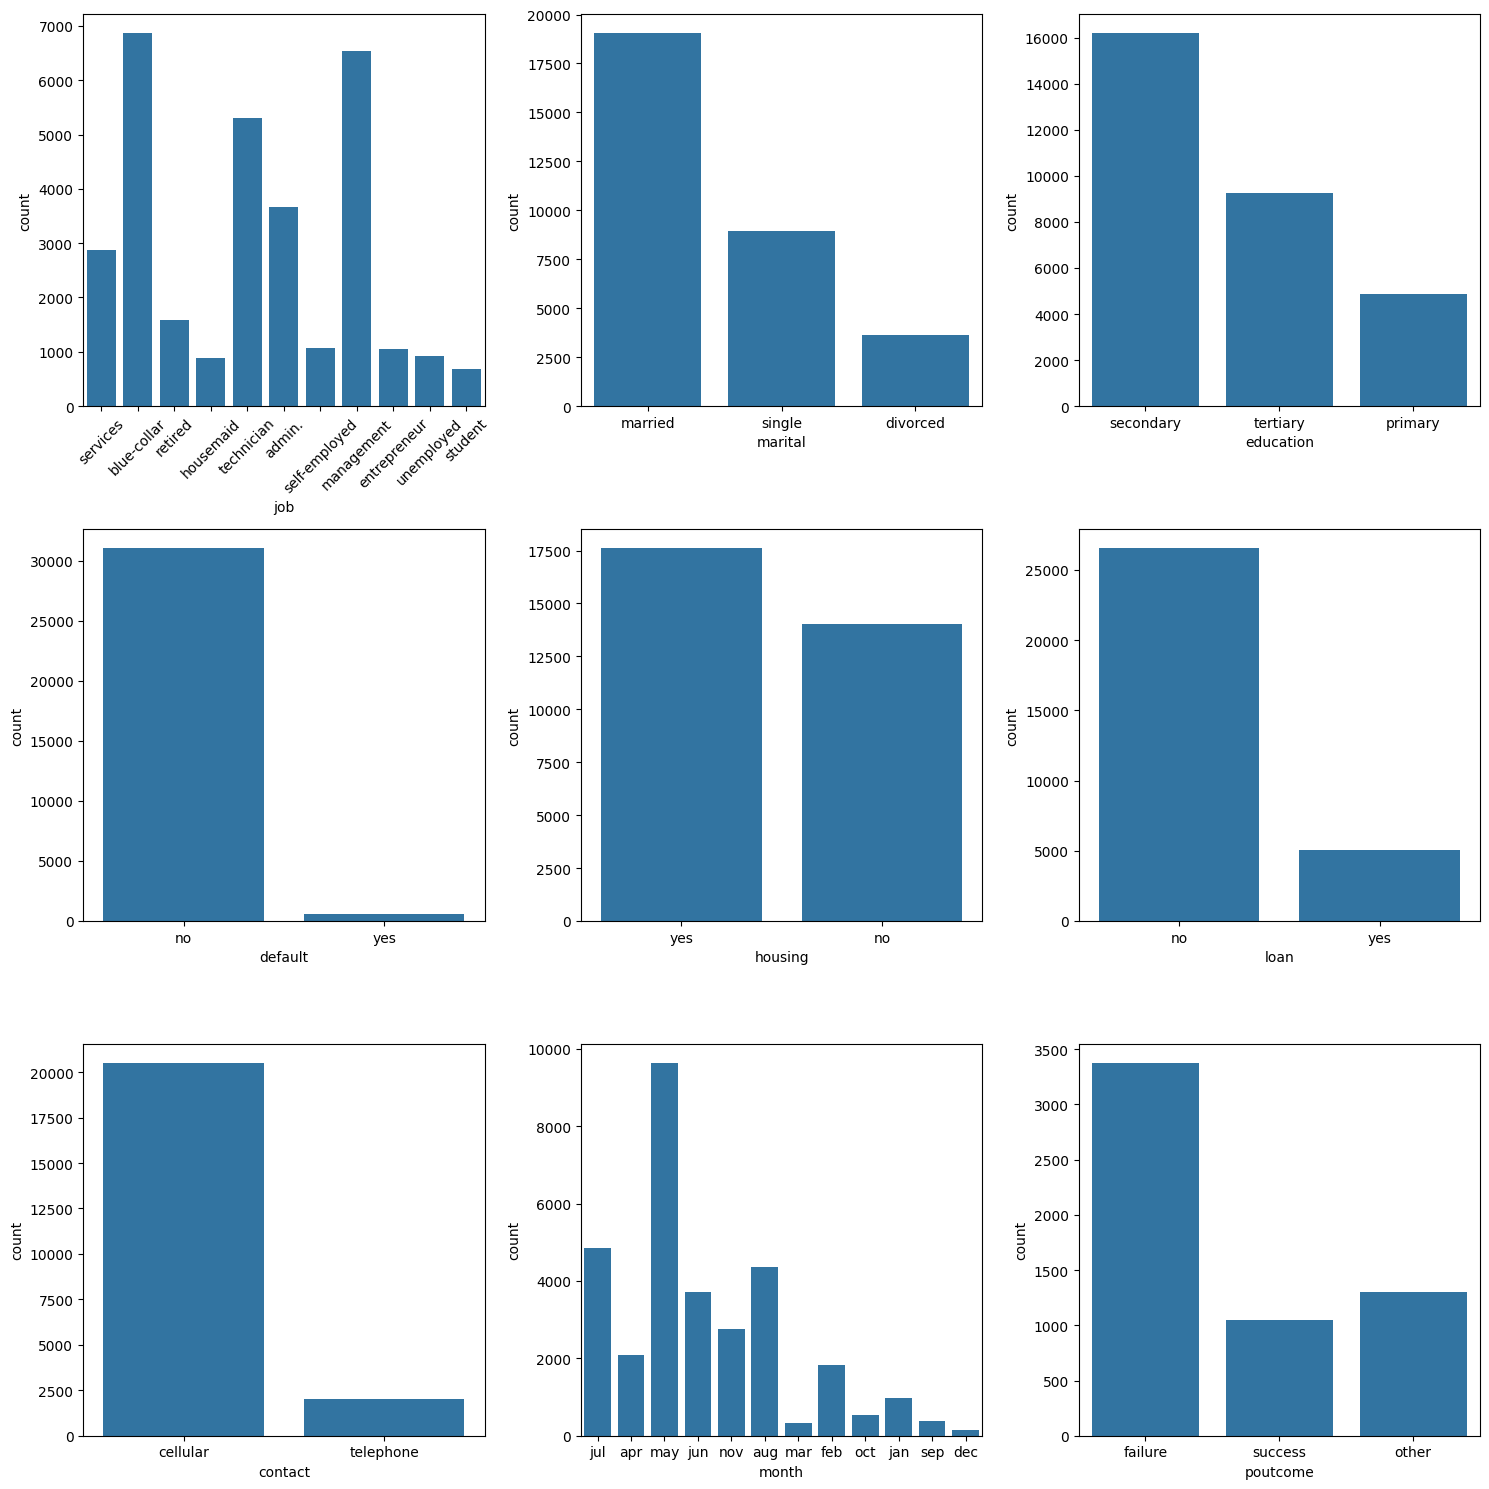

In [14]:
# 범주형 변수 시각화(countplot)
def get_3_countplot_category(data:pd.DataFrame, columns:list, log_scale_threshold: float = 5000):
    """ 데이터와 컬럼을 전달하면 히스토그램을 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
        bar_width_ratio(float): 원하는 비율로 설정 (예시로 0.005 사용)
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        if num_rows == 1:
            col_idx = i  # 수정된 부분
            axes[col_idx].clear()
            n_bins = 'auto'
            sns.countplot(data=data, x=col, ax=axes[col_idx])  # 수정된 부분
            max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
            if max_length > 10:
                for tick in axes[col_idx][0].get_xticklabels():
                    tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용
        else:
            row_idx, col_idx = divmod(i, 3)
            axes[row_idx, col_idx].clear()
            n_bins = 'auto'
            sns.countplot(data=data, x=col, ax=axes[row_idx, col_idx])
            max_length = max(data[col].astype(str).apply(len))  # 열의 최대 길이 계산
            if max_length > 10:
                for tick in axes[col_idx][0].get_xticklabels():
                    tick.set_rotation(45)  # 값이 10글자 이상인 경우 rotation=45 적용

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()
get_3_countplot_category(X_train, category_col)

In [15]:
# NaN까지 포함해서 value_counts (원래 기본값이 dropna=True)
for check_category in category_col:
    display(X_train[check_category].value_counts(dropna=False))

job
blue-collar      6866
management       6530
technician       5306
admin.           3662
services         2879
retired          1590
self-employed    1076
entrepreneur     1044
unemployed        918
housemaid         893
student           677
NaN               206
Name: count, dtype: int64

marital
married     19049
single       8966
divorced     3632
Name: count, dtype: int64

education
secondary    16201
tertiary      9247
primary       4885
NaN           1314
Name: count, dtype: int64

default
no     31083
yes      564
Name: count, dtype: int64

housing
yes    17625
no     14022
Name: count, dtype: int64

loan
no     26573
yes     5074
Name: count, dtype: int64

contact
cellular     20517
NaN           9100
telephone     2030
Name: count, dtype: int64

month
may    9643
jul    4846
aug    4355
jun    3725
nov    2771
apr    2081
feb    1829
jan     986
oct     528
sep     386
mar     337
dec     160
Name: count, dtype: int64

poutcome
NaN        25917
failure     3378
other       1301
success     1051
Name: count, dtype: int64

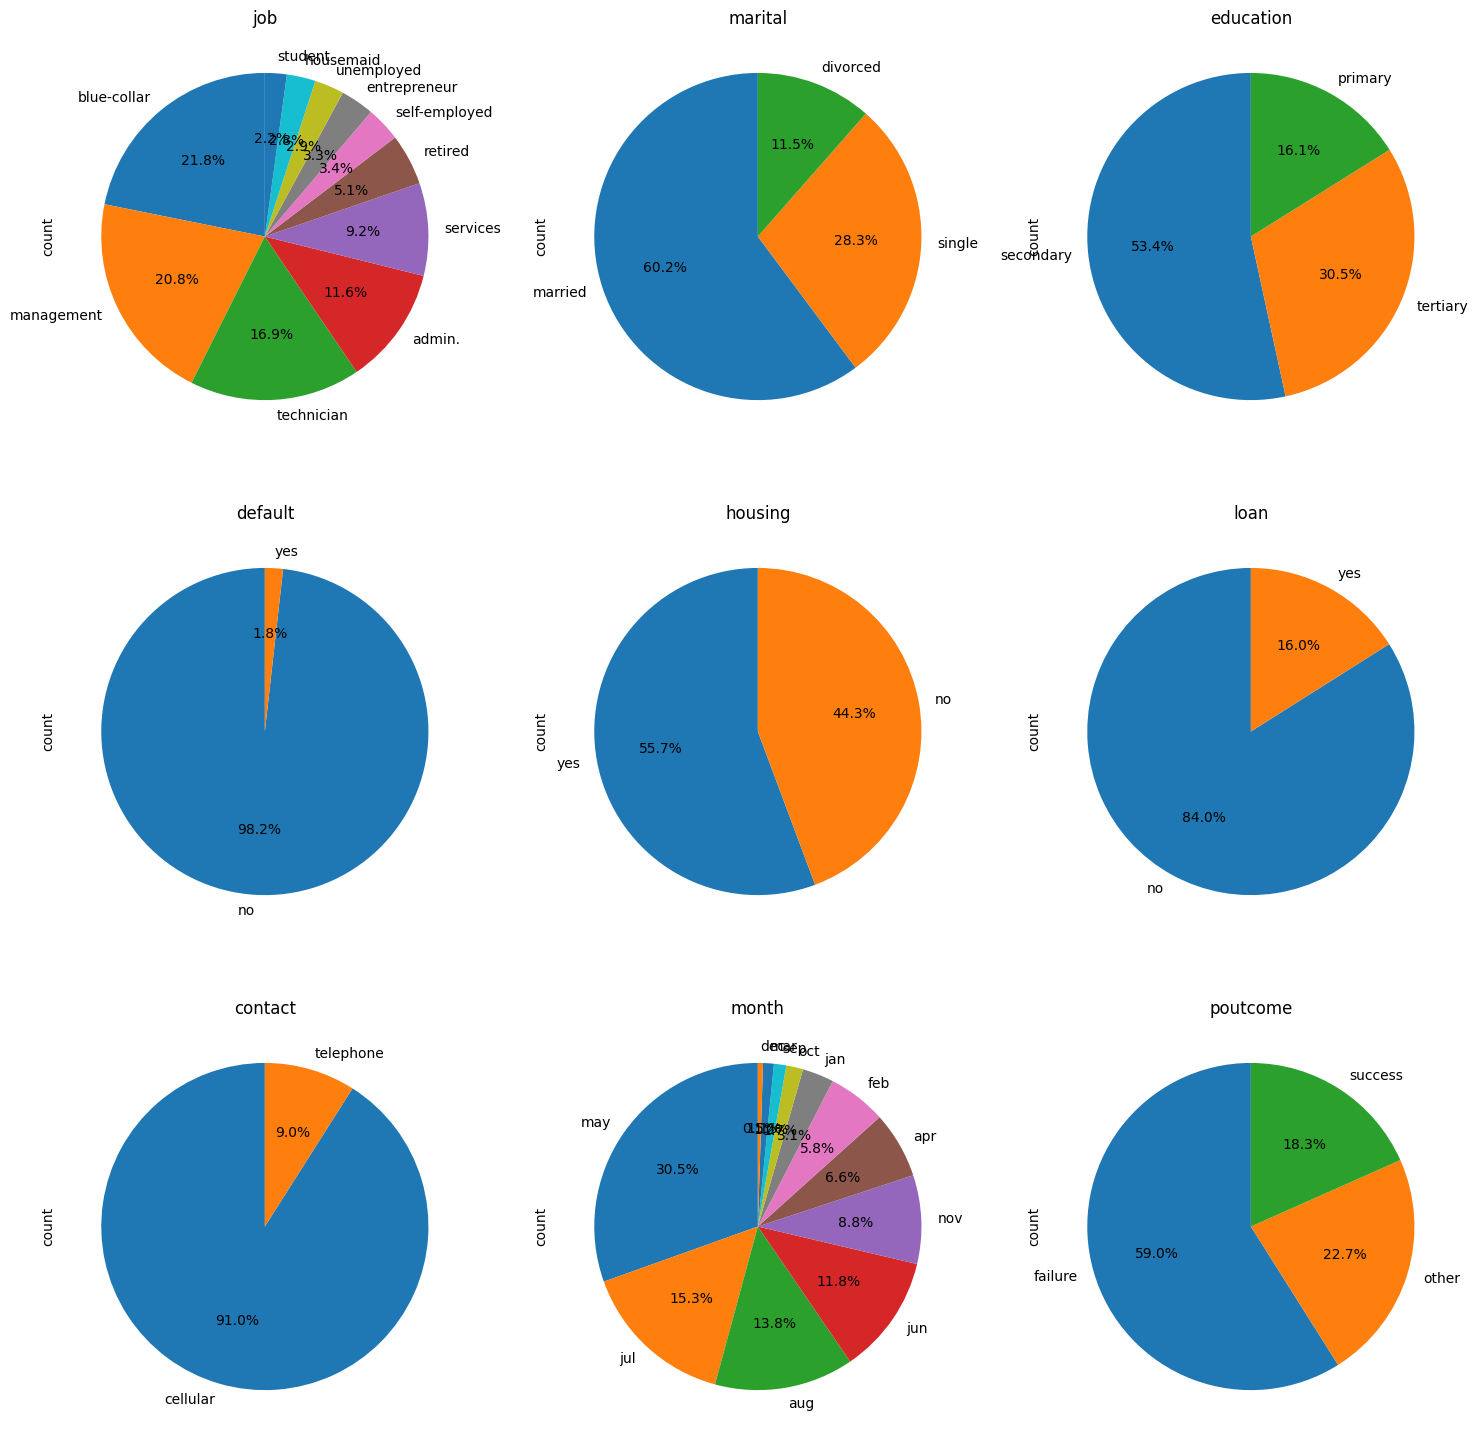

In [16]:
# 범주형 변수 시각화(pie_chart)
def get_3_pie_chart_category(data: pd.DataFrame, columns: list):
    """ 데이터와 컬럼을 전달하면 파이 차트를 3개씩 출력해주는 함수

    Args:
        data (pd.DataFrame): 데이터프레임
        columns (list): 컬럼 리스트
    """
    num_plots = len(columns)
    num_rows = (num_plots + 2) // 3  # 서브플롯의 행 수 계산
    num_cols = min(num_plots, 3)  # 서브플롯의 열 수 계산
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    for i, col in enumerate(columns):
        if num_rows == 1:
            col_idx = i
            axes[col_idx].clear()
            data[col].value_counts().plot.pie(ax=axes[col_idx], autopct='%1.1f%%', startangle=90)
            axes[col_idx].set_aspect('equal')  # 파이 차트가 원형이 되도록 설정
            axes[col_idx].set_title(col)
        else:
            row_idx, col_idx = divmod(i, 3)
            axes[row_idx, col_idx].clear()
            data[col].value_counts().plot.pie(ax=axes[row_idx, col_idx], autopct='%1.1f%%', startangle=90)
            axes[row_idx, col_idx].set_aspect('equal')  # 파이 차트가 원형이 되도록 설정
            axes[row_idx, col_idx].set_title(col)

    # 전체 그림 표시
    plt.tight_layout()
    plt.show()

# 예시로 X_train과 category_col을 사용
get_3_pie_chart_category(X_train, category_col)

In [17]:
# default관련 답변에 따른 결과 비율 확인 ->고려는 해보았으나 따로 적용하여 사용하지는 못하였음
d_yes_n, d_yes_y = df[df['default']=='yes']['y'].value_counts()
d_yes_tot = d_yes_n + d_yes_y
print(100 * d_yes_n / d_yes_tot, 100 * d_yes_y / d_yes_tot)
d_no_n, d_no_y = df[df['default']=='no']['y'].value_counts()
d_no_tot = d_no_n + d_no_y
print(100 * d_no_n / d_no_tot, 100 * d_no_y / d_no_tot)


93.61963190184049 6.380368098159509
88.20389224254437 11.796107757455626


#### 결과(정답) 시각화

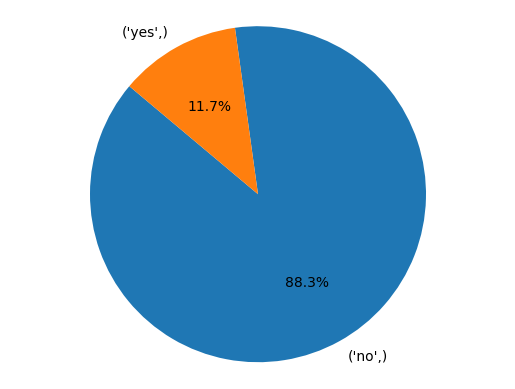

In [18]:
y_train_counts = y_train.value_counts()
plt.pie(y_train_counts, labels=y_train_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # 원형을 유지하도록 하는 옵션
plt.show()

In [19]:
# default가 yes인 사람들에 대해서 기본적인 비율보다 n의 비율이 높아졌는데 
# 아무래도 이미 했으니 더 할 가능성이 더 낮아지는 영향이 있는게 맞는 것 같기도함
defaulty_n, defaulty_y=93.61963190184049, 6.380368098159509
ans_n, ans_y=88.3, 11.7

# 3. 데이터 전처리

## 제일 먼저 데이터 간단히 형식 등 다듬기
- 범주형 데이터 타입 category로 변환 + 몇 컬럼에 대해서는 카테고리 순서 설정(카테고리간 순서의미 부여는 하지 않음)

In [20]:
# 함수화
def type_change_category(data:pd.DataFrame, columns:list):
    for col in columns:
        data[col] = data[col].astype('category')
        # ordered=False로 해주어 순서를 정해주되, 변수 자체에 순서내용까지는 포함시키지 않았다 
        # True로 하니까 무슨 <이런식으로 내용추가되는듯했음
        if col == 'month': # month의 경우 월 순서대로 해주기
            month_names = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
            data[col] = data[col].cat.reorder_categories(month_names, ordered=False)
        elif col == 'marital':
            marital_order = ['single', 'married', 'divorced'] #미혼, 기혼, 이혼 순으로 순서 정해줬음
            data[col] = data[col].cat.reorder_categories(marital_order, ordered=False)
        elif col == 'education':
            edu_order = ['primary', 'secondary', 'tertiary'] #초등교육, 중등교육, 고등교육 순으로 순서 정해줬음
            data[col] = data[col].cat.reorder_categories(edu_order, ordered=False)
    return None

# X_train
type_change_category(X_train, category_col)
# X_test
type_change_category(X_test, category_col)

https://chat.openai.com/share/55c71216-c1b6-48a8-97f4-d6943607d23a  
ordered (bool, default=False): 만약 True로 설정되면, 재배열된 카테고리는 순서가 있는 것으로 간주됩니다. 이 경우, 비교 및 정렬 작업에서 순서가 고려됩니다. False로 설정하면 재배열된 카테고리는 순서가 없는 것으로 간주되며, 정렬 시에는 각 카테고리의 위치만 고려됩니다.

In [21]:
# print(X_train['month'].unique())
# print(X_train['month'].value_counts(sort=False))
# print(X_train['marital'].unique())
# print(X_train['marital'].value_counts(sort=False))
# print(X_train['education'].unique())
# print(X_train['education'].value_counts(sort=False))
# get_3_countplot_category(X_train, category_col)

## 이상치 제거
- previous에서 값 250넘는 이상치 제거
- 제거 다 하고 나서 꼭 인덱스 초기화 해주자

In [22]:
'''
previous 관련 값자기 250넘는 값 갑자기 왜 존재했는지 알면 좋을듯하나 그것은 알기 힘들듯하니
250넘는 값이 몇개나 존재하고 있고, 250 넘는 값중 최소값은 무엇이며 또 그 데이터에 한해서 결과가 어떻게 나왔는지 확인해본다
X_train[X_train['previous']>250].count() # 단 한개만 존재
X_test[X_test['previous']>250].count() # 테스트 데이터에는 존재 X
display(y_train[X_train['previous']>250]['y']) # 둘의 인덱스 동일할 것이니 저런식으로 사용해줬는데 아마 맞는듯?
df[df['previous']>250]['y']
쨰든 분리하기 전 데이터로 확인 했을 때도 no로 나왔기에 yes였다면 조금 더 고민해봤겠지만 no라서 삭제!

추가로 balance의 값중에 -2000 밑으로 꽤 뚝떨어져서 log스케일화 후 뚝 떨어져서 존재하게 되므로 삭제해주었다
(train data 11개, test data 3개가 제거되었다)
'''

"\nprevious 관련 값자기 250넘는 값 갑자기 왜 존재했는지 알면 좋을듯하나 그것은 알기 힘들듯하니\n250넘는 값이 몇개나 존재하고 있고, 250 넘는 값중 최소값은 무엇이며 또 그 데이터에 한해서 결과가 어떻게 나왔는지 확인해본다\nX_train[X_train['previous']>250].count() # 단 한개만 존재\nX_test[X_test['previous']>250].count() # 테스트 데이터에는 존재 X\ndisplay(y_train[X_train['previous']>250]['y']) # 둘의 인덱스 동일할 것이니 저런식으로 사용해줬는데 아마 맞는듯?\ndf[df['previous']>250]['y']\n쨰든 분리하기 전 데이터로 확인 했을 때도 no로 나왔기에 yes였다면 조금 더 고민해봤겠지만 no라서 삭제!\n\n추가로 balance의 값중에 -2000 밑으로 꽤 뚝떨어져서 log스케일화 후 뚝 떨어져서 존재하게 되므로 삭제해주었다\n(train data 11개, test data 3개가 제거되었다)\n"

11
balance
-6847    1
-8019    1
-4057    1
-2093    1
-2827    1
-2712    1
-2082    1
-2049    1
-3313    1
-2122    1
-2604    1
Name: count, dtype: int64


<Axes: xlabel='balance', ylabel='Count'>

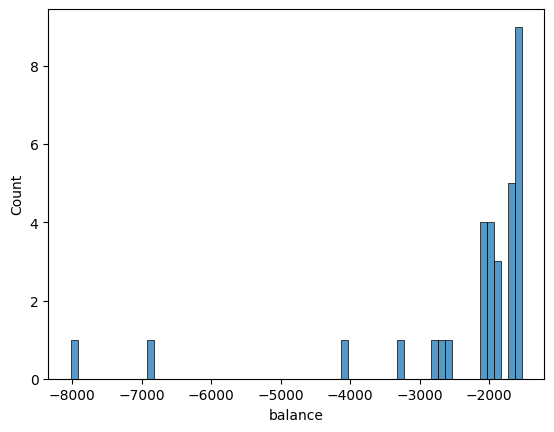

In [23]:
print(X_train[X_train['balance']<-2000]['balance'].count())
print(X_train[X_train['balance']<-2000]['balance'].value_counts())
sns.histplot(data = X_train[X_train['balance']<-1500], x = 'balance', binwidth=100)

3
balance
-3372    1
-2282    1
-3058    1
Name: count, dtype: int64


<Axes: xlabel='balance', ylabel='Count'>

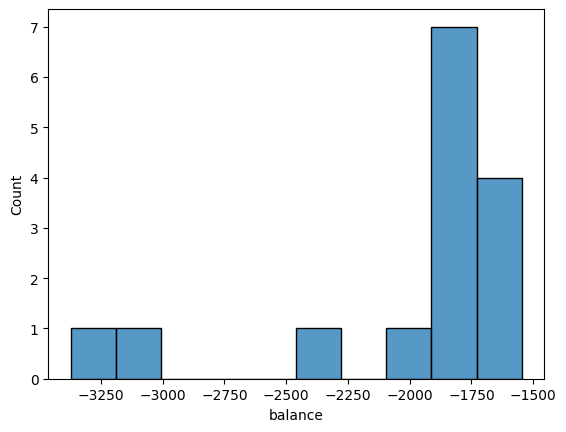

In [24]:
print(X_test[X_test['balance']<-2000]['balance'].count())
print(X_test[X_test['balance']<-2000]['balance'].value_counts())
sns.histplot(data = X_test[X_test['balance']<-1500], x = 'balance')

In [25]:
# 이상치 제거
def remove_outliers(X_data:pd.DataFrame, y_data:pd.DataFrame):
    condition = X_data['previous'] < 250
    condition2 = X_data['balance'] > -2000
    X_data = X_data[condition & condition2] # 일단 간단하게 테스트용으로 해보자
    y_data = y_data[condition & condition2]
    X_data.reset_index()
    y_data.reset_index()
    return X_data, y_data

X_train, y_train = remove_outliers(X_train, y_train)
X_test, y_test = remove_outliers(X_test, y_test)

C:\Users\kssg1\AppData\Local\Temp\ipykernel_18972\1178725451.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


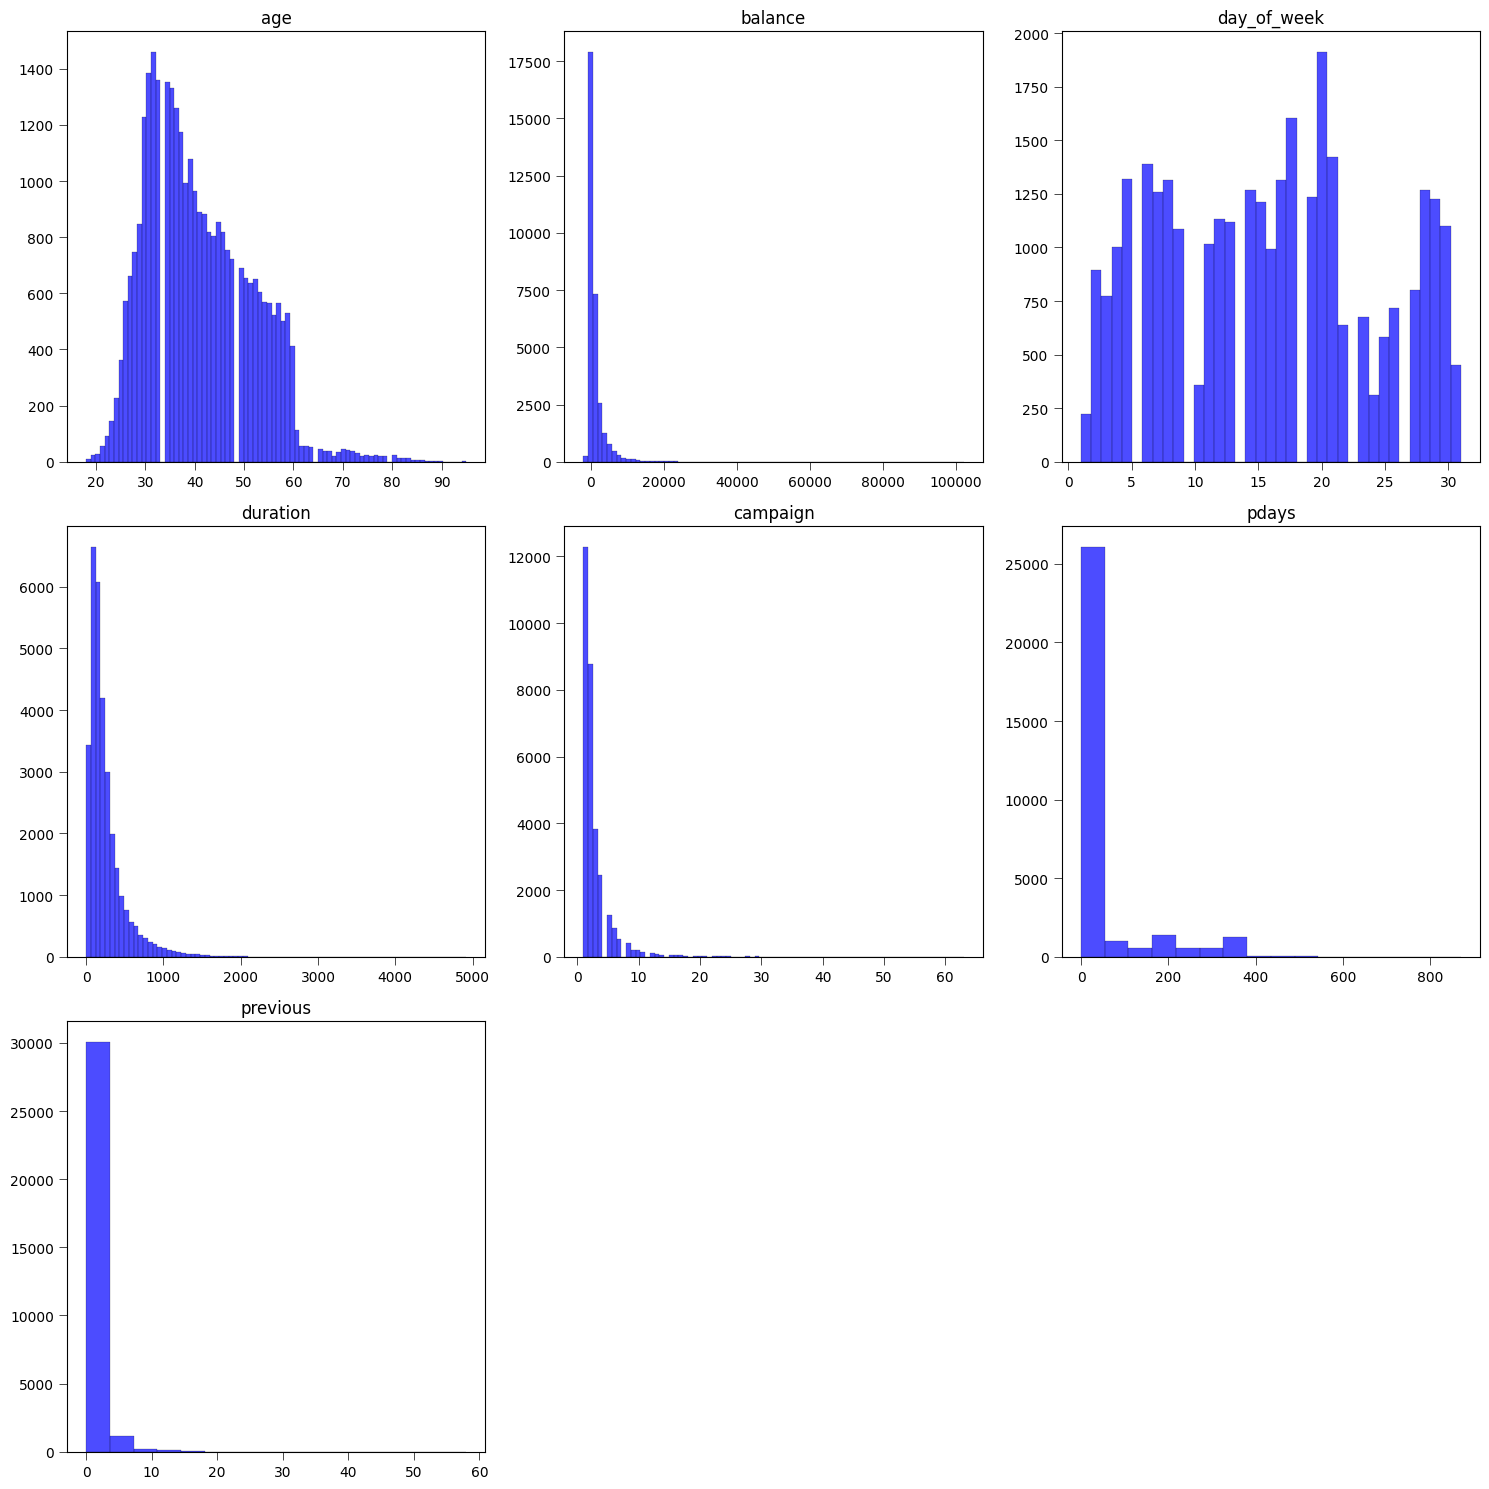

In [26]:
get_3_hist_num(X_train, numeric_col, whether_log_scale=False)

## OverSampling해서 데이터 비율 맞춰주기
- 단, SMOTE 알고리즘은 수치형 데이터에만 쓸 수 있으니
- SMOTE를 범주형 데이터에도 쓸 수 있게 확장한 SMOTENC를 사용

In [27]:
smnc = SMOTENC(categorical_features=category_col, random_state=42)
X_train, y_train = smnc.fit_resample(X_train, y_train)
X_test, y_test = smnc.fit_resample(X_test, y_test)

### oversampling한 뒤 결과 데이터 확인하기

In [28]:
X_train.info()
print(X_train.isna().sum())
display(X_train.describe())
display(X_train.describe(include=['category']))
# X_train.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55866 entries, 0 to 55865
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Unnamed: 0   55866 non-null  int64   
 1   age          55866 non-null  int64   
 2   job          55570 non-null  category
 3   marital      55866 non-null  category
 4   education    54278 non-null  category
 5   default      55866 non-null  category
 6   balance      55866 non-null  int64   
 7   housing      55866 non-null  category
 8   loan         55866 non-null  category
 9   contact      44572 non-null  category
 10  day_of_week  55866 non-null  int64   
 11  month        55866 non-null  category
 12  duration     55866 non-null  int64   
 13  campaign     55866 non-null  int64   
 14  pdays        55866 non-null  int64   
 15  previous     55866 non-null  int64   
 16  poutcome     12207 non-null  category
dtypes: category(9), int64(8)
memory usage: 3.9 MB
Unnamed: 0         0
ag

,Unnamed: 0,age,balance,day_of_week,duration,campaign,pdays,previous
count,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000
mean,27173.101672,40.866484,1562.884259,15.381574,372.684943,2.352146,49.305105,0.736172
std,13587.724519,10.925302,3243.691011,8.119338,333.580126,2.610327,101.016207,2.025314
min,0.000000,18.000000,-1968.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,15578.250000,32.000000,130.000000,8.000000,146.000000,1.000000,-1.000000,0.000000
50%,29946.500000,39.000000,563.000000,15.000000,261.000000,2.000000,-1.000000,0.000000
75%,40184.000000,48.000000,1753.000000,21.000000,502.000000,3.000000,55.000000,0.000000
max,45210.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,58.000000


,job,marital,education,default,housing,loan,contact,month,poutcome
count,55570,55866,54278,55866,55866,55866,44572,55866,12207
unique,11,3,3,2,2,2,2,12,3
top,management,married,secondary,no,no,no,cellular,may,success
freq,14885,33788,29556,55295,31602,50258,42195,13514,5810


수치형에 대해서는 약간은 평균이나 표준편차가 변하긴 했는데 얼추 양상은 비슷한듯 예상이 되므로 문제 없이 잘 된듯하다     
하지만 범주형에 대해서는 job, housing, poutcome이 최빈값이 바뀌었다     
아마 이 요소들이 결과적으로 y의 값이 yes가 될려면 더 나타나야했던 값이 아닐까라는 생각이 든다   
일단은 저 패키지를 믿고 그대로 진행해보도록 하겠다

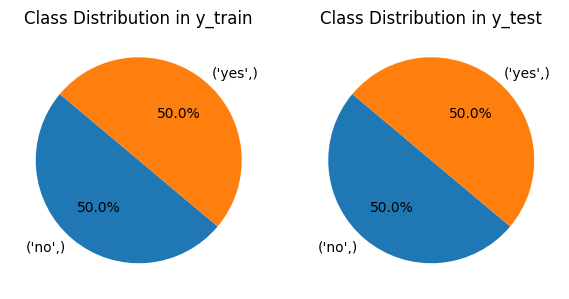

In [29]:
# 반반 되었는지 확인 -> 확인결과 반반되었음
y_train_counts = y_train.value_counts()
y_test_counts = y_test.value_counts()

datasets = [(y_train, 'Class Distribution in y_train'),
            (y_test, 'Class Distribution in y_test')]

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

# 반복문을 사용하여 각 데이터셋의 클래스 분포 시각화
for i, (dataset, title) in enumerate(datasets):
    value_counts = dataset.value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(title)

# 그래프 보여주기
plt.tight_layout()
plt.show()

## 결측치 처리 
(참고로 test 데이터 기준으로는 데이터 총 31647, 전체 데이터로는 45211)
- 수치형: contact(9100), poutcome(25917)
- 범주형: job(206), education(1314)
- 삭제 : -  
처리하기 애매하다는 느낌 일단 내버려두고 차차 더 생각


## 전처리(스케일링 & 인코딩)

### 수치형 데이터 전처리

#### right skew가 큰 수치형 데이터에 대해서 log스케일 적용 정확히는 log1p (log(1+x))로 변환시켜줌
- 해줄 대상:    
    튜터님은 'duration','balance','previous' 이렇게만 해주셨지만    
    내가 생각할 때는 'balance', 'duration', 'campaign', 'pdays', 'previous' 이렇게 2개 제외하고 전부 해줄 생각이다

In [30]:
#balance의 값은 음수가 있기 때문에 최소값을 보정함
balance_min = abs(min(X_train['balance'].min(), X_test['balance'].min()))
X_train['balance'] = X_train['balance'] + balance_min
X_test['balance'] = X_test['balance'] + balance_min

#pdays도 표현상 이전 캠페인에서 연락한 적이 없다면 -1로 표시해놨기 때문에 음수가 있다 따라서 +1해줘서 음수를 없애준다
X_train['pdays'] = X_train['pdays'] + 1
X_test['pdays'] = X_test['pdays'] + 1

# 로그스케일 적용
for col in ['balance', 'duration', 'campaign', 'pdays', 'previous']:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])

In [31]:
display(X_train.describe())

,Unnamed: 0,age,balance,day_of_week,duration,campaign,pdays,previous
count,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000,55866.000000
mean,27173.101672,40.866484,8.006420,15.381574,5.547323,1.066719,1.441029,0.301679
std,13587.724519,10.925302,0.500990,8.119338,0.929603,0.468592,2.258368,0.584119
min,0.000000,18.000000,2.564949,1.000000,0.000000,0.693147,0.000000,0.000000
25%,15578.250000,32.000000,7.654917,8.000000,4.990433,0.693147,0.000000,0.000000
50%,29946.500000,39.000000,7.841493,15.000000,5.568345,1.098612,0.000000,0.000000
75%,40184.000000,48.000000,8.225235,21.000000,6.220590,1.386294,4.043051,0.000000
max,45210.000000,95.000000,11.553184,31.000000,8.500861,4.158883,6.771936,4.077537


C:\Users\kssg1\AppData\Local\Temp\ipykernel_18972\1178725451.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  num_bin = entire_range / bin_width


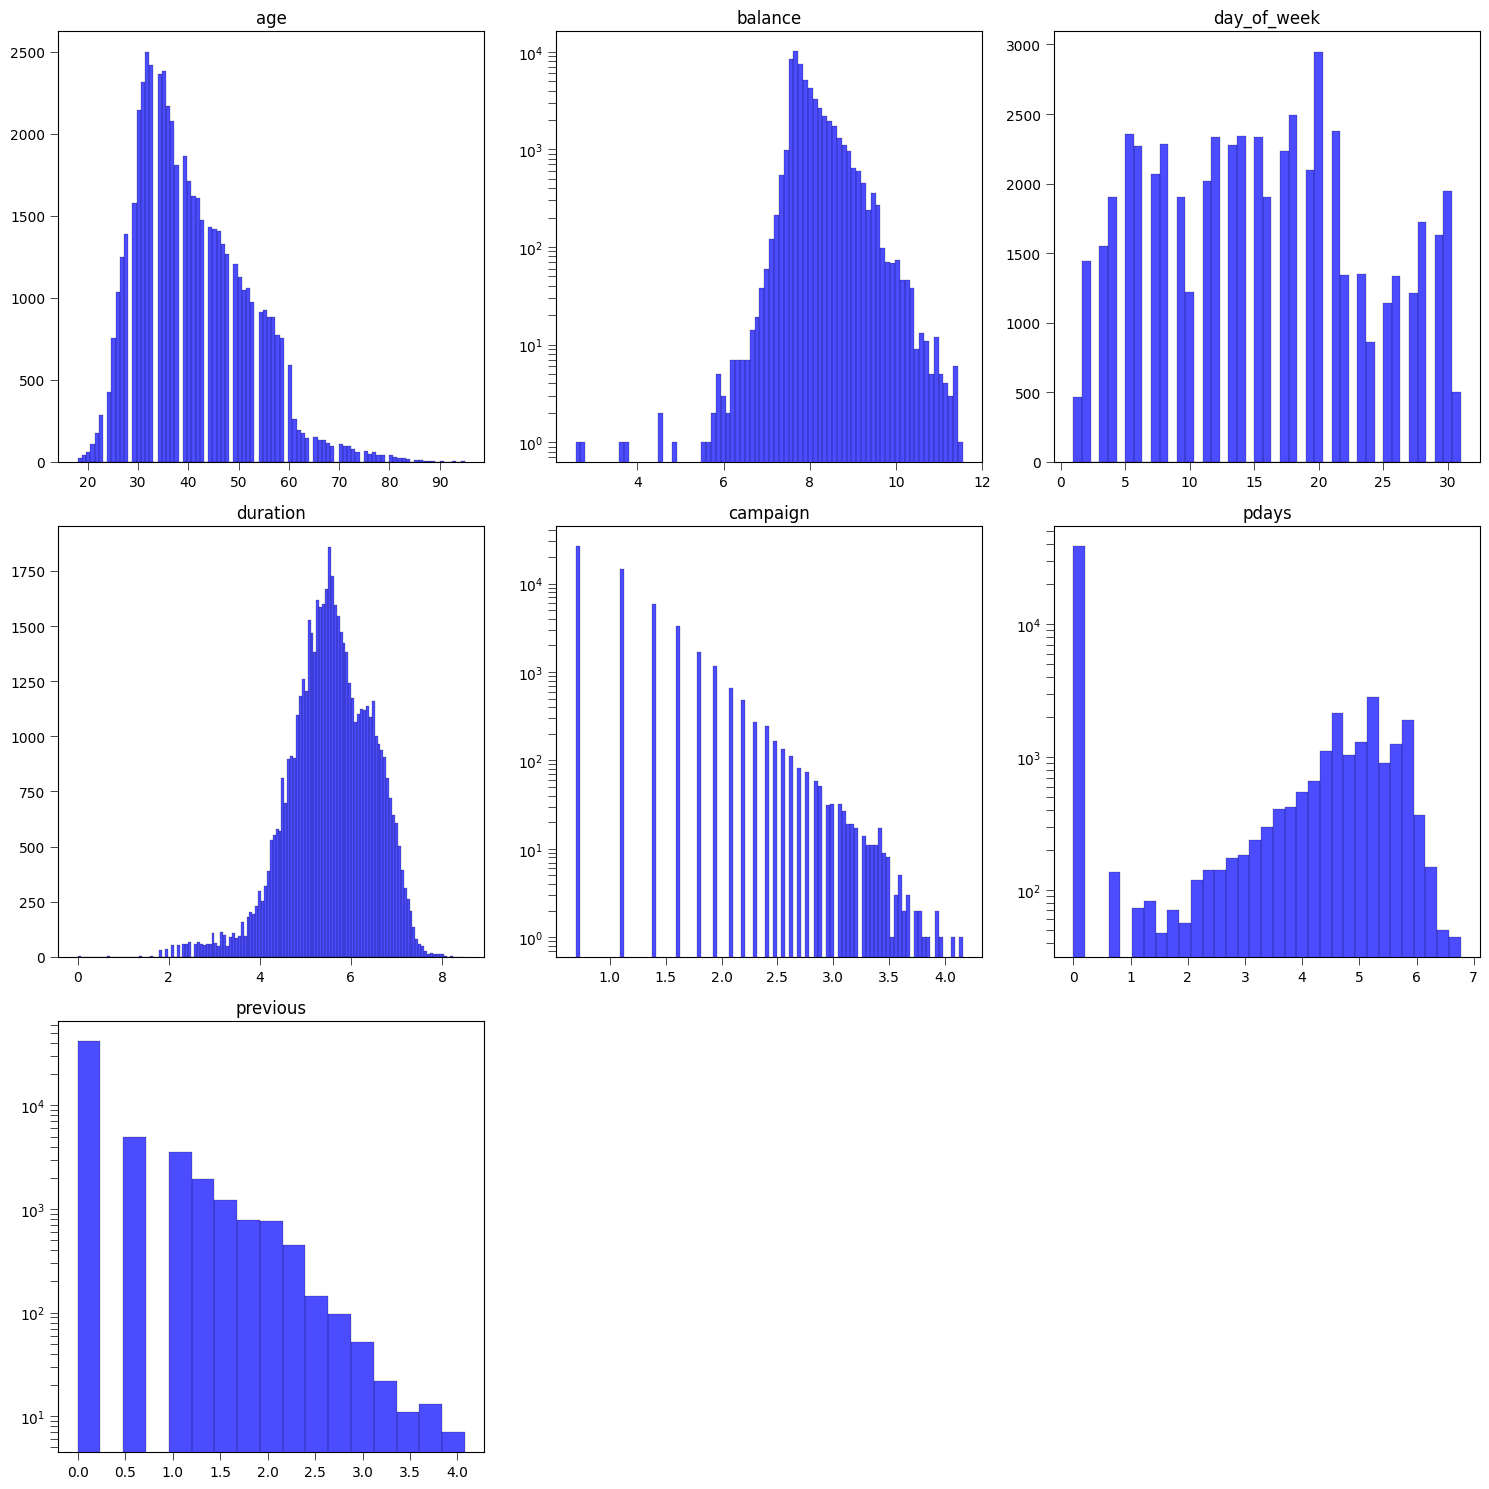

In [32]:
#로그스케일 변환 후 시각화
get_3_hist_num(X_train, numeric_col)

#### 스케일링 (로그스케일화 시키고 나서 추가 생각)
- 수치형 데이터: 'age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous'
- 표준화(sd_sc): 'pdays'
- 정규화(mm_sc): 'age','duration','day_of_week','balance','campaign', 'previous'

In [33]:
def get_numeric_sc(X_train:pd.DataFrame, X_test:pd.DataFrame):
    """데이터를 전달받아 수치형 변수 스케일링하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임

    Returns:
        pd.DataFrame, pd.DataFrame: train, test 데이터프레임
    """
    # 수치형변수
    # age, balance, day_of_week, duration, campaign, pdays,previous
    
    #StandardScaler 적용할 변수 리스트
    sc_col = ['pdays']
    #MinMaxScaler 적용할 변수 리스트
    mm_col = ['age','duration','day_of_week','balance','campaign','previous']
    
    #모델 가져오기
    sd_sc = StandardScaler()
    mm_sc = MinMaxScaler()

    #train, test 데이터변환(Standard Scaler이용)
    sd_sc.fit(X_train[sc_col])
    X_train[sc_col] = sd_sc.transform(X_train[sc_col])  #컬럼추가안해주고 바로 바꾸는지?
    X_test[sc_col] = sd_sc.transform(X_test[sc_col])
    
    #train, test 데이터변환(MinMax Scaler이용)
    mm_sc.fit(X_train[mm_col])
    X_train[mm_col] = mm_sc.transform(X_train[mm_col])
    X_test[mm_col] = mm_sc.transform(X_test[mm_col])
    
    return X_train, X_test

# X_train, X_test = get_numeric_sc(X_train, X_test) # 테스트용 실제 실행은 아래서 할 것임

### 범주형 데이터 전처리 (인코딩)
- 범주형 데이터: 'job','marital','education','default','housing','loan','contact','month','poutcome'
- label encoding(le): ('marital', 'education'(할려면 범주 찾아서 다시 정렬해주긴 해야함), 'month') 정도 고려중인데 굳이 해줘야할까 생각중
- onehot encoding(oe) & get_dummies(gd): 둘중 하나로 통일해서 전부 해볼 듯하다

#### 문제2: Y 변수 인코딩 적용하기

In [34]:
def get_binary(x):
    # 들어오는 값이 no면 0 yes면 1로 리턴해준다
    if x == 'no':
        return 0
    else:
        return 1

# 확인용 미리 저장
y_train_original = y_train.copy()
y_test_original = y_test.copy()

# y_train 데이터 인코딩 코드
y_train['y'] = y_train['y'].apply(get_binary)
# y_test 데이터 인코딩코드
y_test['y'] = y_test['y'].apply(get_binary)

#잘 적용되었는지 확인
display(y_train_original[10:21])
display(y_train[10:21])

,y
10,no
11,no
12,no
13,no
14,no
15,no
16,no
17,no
18,no
19,no


,y
10,0
11,0
12,0
13,0
14,0
15,0
16,0
17,0
18,0
19,0


#### 범주형 변수 인코딩
우선적으로 그냥 get_dummies로 하고 시간 여유가 된다면 후에 더 건드려볼듯 함

In [35]:
def get_category(X_train:pd.DataFrame, X_test:pd.DataFrame):
    """ 데이터를 전달받아 범주형 변수 더미화하는 함수

    Args:
        X_train (pd.DataFrame): train 데이터프레임
        X_test (pd.DataFrame):  test 데이터프레임

    Returns:
        pd.DataFrame, pd.DataFrmae, list: train, test 데이터프레임, 더미화된 컬럼
    """
    
    #범주형변수
    # 'job','marital','education','default','housing','loan','contact','month','poutcome'
    
    #범주형 컬럼 더미화 하기
    X_train_dummies = pd.get_dummies(X_train[category_col])
    X_test_dummies = pd.get_dummies(X_test[category_col])
    
    # 더미화한 변수를 기존 데이터셋에 합치기
    X_train = pd.concat([X_train, X_train_dummies], axis = 1)
    X_test = pd.concat([X_test, X_test_dummies], axis = 1)
    
    return X_train, X_test, X_train_dummies.columns.to_list()
    

# X_train, X_test, col_dummies = get_category(X_train,X_test) #테스트용 실제 실행은 아래서 할 것임

# 4. 모델 수립
- lor, dt, rf, knn, gbm, xgb, lgb
- 우선적으로 rf와 dt를 통해 각 변수들의 중요도 등을 한 번 먼저 살펴볼 계획
- 그리고 다시 추가적으로 조치 취해볼 수 있을지 등에 대해 고민

#### 문제3: 모델링 & 평가함수 생성하기
- 모델링과 평가함수 분리할까도 생각중

In [36]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list, model_type:str = 'rf'):
    """ train과 test 데이터와 X변수 컬럼을 받아 평가지표를 내는 함수입니다.

    Args:
        train (pd.DataFrame): train 데이터프레임
        test (pd.DataFrame): test 데이터프레임
        x_var_list (list): 모델링에 사용할 변수 리스트
        model_type(str) : 무슨 모델 쓸지 결정 (default : 'rf')
    """
    #외부 전달인자를 내부변수에 할당
    X_train = train 
    X_test = test

    #일부 컬럼만 가져오기
    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    #모델가져오기 & 학습하기    &   # 학습하여 결과 저장
    if model_type in ['lor', 'dt', 'rf', 'knn', 'gbm', 'xgb', 'lgb']:
        if model_type == 'lor':
            from sklearn.linear_model import LogisticRegression
            model_lor = LogisticRegression()
            model_lor.fit(X_train, y_train)
            y_pred_train = model_lor.predict(X_train)
            y_pred_test = model_lor.predict(X_test)
            
        elif model_type == 'dt':
            from sklearn.tree import DecisionTreeClassifier
            model_dt = DecisionTreeClassifier(random_state=42)
            model_dt.fit(X_train, y_train)
            y_pred_train = model_dt.predict(X_train)
            y_pred_test = model_dt.predict(X_test)
            
        elif model_type == 'rf':
            from sklearn.ensemble import RandomForestClassifier
            model_rf = RandomForestClassifier(random_state=42)
            model_rf.fit(X_train, y_train)
            y_pred_train = model_rf.predict(X_train)
            y_pred_test = model_rf.predict(X_test)
            
        elif model_type == 'knn':
            from sklearn.neighbors import KNeighborsClassifier
            model_knn = KNeighborsClassifier()
            model_knn.fit(X_train, y_train)
            y_pred_train = model_knn.predict(X_train)
            y_pred_test = model_knn.predict(X_test)
            
        elif model_type == 'gbm':
            from sklearn.ensemble import GradientBoostingClassifier
            model_gbm = GradientBoostingClassifier(random_state= 42)
            model_gbm.fit(X_train, y_train)
            y_pred_train = model_gbm.predict(X_train)
            y_pred_test = model_gbm.predict(X_test)
            
        elif model_type == 'xgb':
            from xgboost import XGBClassifier
            model_xgb = XGBClassifier(random_state= 42)
            model_xgb.fit(X_train, y_train)
            y_pred_train = model_xgb.predict(X_train)
            y_pred_test = model_xgb.predict(X_test)
            
        elif model_type == 'lgb':
            from lightgbm import LGBMClassifier
            model_lgb = LGBMClassifier(random_state= 42)
            model_lgb.fit(X_train, y_train)
            y_pred_train = model_lgb.predict(X_train)
            y_pred_test = model_lgb.predict(X_test)
    
    #평가표 생성
    result = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train), f1_score(y_test, y_pred_test)]},
                            index = ['train','test'])
    
    print(model_type,"사용시")
    display(result.round(5))

#### 문제4: 전체 모델링 수행하기

In [37]:
X_train, X_test = get_numeric_sc(X_train, X_test)
X_train, X_test, col_dummies = get_category(X_train,X_test)

# 5. 평가
- 정확도(Accuracy)
- f1-score

In [38]:
get_score(X_train, X_test, col_dummies + numeric_col)

c:\Users\kssg1\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


rf 사용시


,acc,f1_score
train,1.00000,1.00000
test,0.89148,0.88953


## (선택, 서술형): 더 개선할 수 있는 점 생각해보기
- ex1) 왜 balance 음수 값을 보정해야 했을까요?    
- ex2) 왜 수치형 변수 변환 시 np.lop()가 아닌 np.log1p() 수행했을까요?    
- ex3) get_category 함수는 모든 범주형 변수에 더미 변환을 적용했는데 더 나은 방법이 있을까요?